# InceptionResNetV2
- https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_resnet_v2/InceptionResNetV2

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

---
## pytorch - Transfer Learning
- https://github.com/AndersonJo/pytorch-examples/blob/master/10%20%5BTL%5D%20Transfer%20Learning.ipynb
---

#### 실질적 조언
##### 새로 훈련할 데이터가 적지만 original 데이터와 유사할 경우
- 데이터의 양이 적어 fine-tune (전체 모델에 대해서 backpropagation을 진행하는 것) 은 over-fitting의 위험이 있기에 하지 않습니다.
새로 학습할 데이터는 original 데이터와 유사하기 때문에 이 경우 최종 linear classfier 레이어만 학습을 합니다.

##### 새로 훈련할 데이터가 매우 많으며 original 데이터와 유사할 경우
- 새로 학습할 데이터의 양이 많다는 것은 over-fitting의 위험이 낮다는 뜻이므로, 전체 레이어에 대해서 fine-tune을 합니다.

##### 새로 훈련할 데이터가 적으며 original 데이터와 다른 경우
- 데이터의 양이 적기 때문에 최종 단계의 linear classifier 레이어를 학습하는 것이 좋을 것입니다. 반면서 데이터가 서로 다르기 때문에 거의 마지막부분 (the top of the network)만 학습하는 것은 좋지 않습니다. 서로 상충이 되는데.. 이 경우에는 네트워크 초기 부분 어딘가 activation 이후에 특정 레이어를 학습시키는게 좋습니다.

##### 새로 훈련할 데이터가 많지만 original 데이터와와 다른 경우
- 데이터가 많기 때문에 아예 새로운 ConvNet을 만들수도 있지만, 실적적으로 transfer learning이 더 효율이 좋습니다. 전체 네트워크에 대해서 fine-tune을 해도 됩니다.

#### Code

- 아래 예제의 코드에서는 Inception v3를 사용합니다.
Inception v3는 ImageNet이라는 데이터를 분류하는데 학습이 되어 있으며 여기에는 새로 학습할 데이터 '개미' 그리고 '벌' 이 이미 있습니다.
새로 학습할 데이터의 양이 적지만, 기존 모델이 학습한 ImageNet의 데이터와 유사하기 때문에
전체 fine-tuning을 하지 않고 최종 linear classifier layer부분만 학습하는 방식을 택했습니다.

- 실제 fine-tune (전체 네트워크 학습)시에는 오히려 accuracy가 0.6수준으로 떨어져 버립니다.

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import models
import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
USE_CUDA = torch.cuda.is_available()
BATCH_SIZE = 6
FINE_TUNE = False # True: 전체 네트워크 학습, False: 최종 마지막 network만 학습

In [8]:
# https://pytorch.org/docs/stable/torchvision/models.html
# https://github.com/pytorch/vision/tree/master/torchvision/models
# 미리 사용할 모델의 Input 파악 필수!

train_transform = transforms.Compose([  #이미지를 변형시켜주는 것임
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(), # 이미지 좌우 반전 ()안은 확률로 실시
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1] 
    # 픽셀값을 (0~255)에서 (0.0~1.0)으로 자동 변환[파이토치 tensors타입으로 변형]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_data = dsets.ImageFolder('./이미지/train/', train_transform)
test_data = dsets.ImageFolder('./이미지/test/', test_transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

Visualize data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


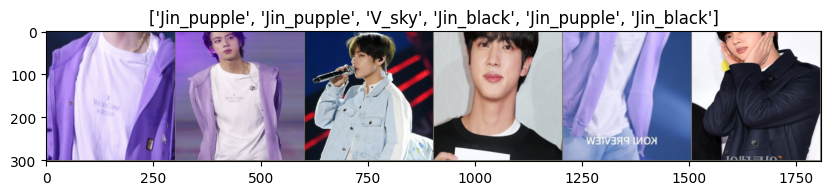

In [9]:
def sample_show():
    # Get a batch of training data
    inp, classes = next(iter(train_loader))
    title = [train_data.classes[i] for i in classes]
    # Make a grid from batch
    inp = torchvision.utils.make_grid(inp, nrow=8)
    
    plt.figure(figsize=(10, 10))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

sample_show()

ConvNet as fixed feature extractor
- ConvNet as fixed feature extractor 기법은 fine-tune처럼 전체 network를 모두 training시키는 기법이 아니라,
마지막 classifier 부분만 학습시킵니다.

이경우 이미 학습된 모델을 가져온뒤 마지막 fully-connected layer부분만 새로 만듭니다.
학습시 마지막 fully-connected layer만 학습되게 하고 나머지 layers들은 학습되지 않도록 막습니다.

---

# 23.02.11. - InceptionResnetV2 : Fine-Tuning Try1

In [2]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Note that in this code num_classes is the number of classes in your image classification problem, 
# and X_train and y_train are the input and target data for training, 
# and X_test and y_test are the input and target data for validation.
# 
# The input data, X, should be preprocessed to have the shape (num_samples, 224, 224, 3), 
# where num_samples is the number of samples in your data, and the target data, y, should be one-hot encoded.


# Load the InceptionResNetV2 model
base_model = InceptionResNetV2(weights='imagenet', include_top=False)

# Add a GlobalAveragePooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy')

# Preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

# Train the model on your data
# model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Use the model to make predictions
img = preprocess_image('path/to/image.jpg')
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])
print(predicted_class)


# V2-2

In this code, train_data_gen and val_data_gen are instances of the ImageDataGenerator class  
that are used to generate batches of training  
and validation data, num_classes is the number of classes in your dataset,   
epochs is the number of epochs to train the model,   
and train_steps and val_steps are the number of steps per epoch for the training and validation data, respectively.

Note that you will need to modify this code to match the specifics of your data and use case.  
For example, you may need to change the image size, the number of classes, or the data generator to match your data.

In [ ]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# Load the pre-trained InceptionResNetV2 model
base_model = InceptionResNetV2(weights='imagenet', include_top=False)

# Add a GlobalAveragePooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)

# Add the final layer for classification
predictions = Dense(num_classes, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Train the top layers on the data
model.fit_generator(train_data_gen, steps_per_epoch=train_steps, epochs=epochs, validation_data=val_data_gen, validation_steps=val_steps)

# Fine-tune the model by unfreezing the base model layers
for layer in base_model.layers:
    layer.trainable = True

# Recompile the model
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the data
model.fit_generator(train_data_gen, steps_per_epoch=train_steps, epochs=epochs, validation_data=val_data_gen, validation_steps=val_steps)


# V2-3

num_classes를 데이터의 클래스 수로 바꾸고 X_train 및 y_train을 훈련 데이터로 바꿔야 합니다. 또한 데이터와 원하는 성능을 기반으로 완전 연결 계층의 숨겨진 단위 수 및 교육 에포크 수와 같은 하이퍼파라미터를 조정해야 할 수도 있습니다. 또한 작은 데이터 세트를 처리할 때 데이터 확대 기술을 사용하여 데이터 세트의 크기를 인위적으로 늘리고 모델 성능을 향상시키는 것을 고려할 수도 있습니다.

In [3]:
# Load the InceptionResNetV2 model with pre-trained weights
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

# Add a GlobalAveragePooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer for the classification
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Train the model on your data
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), class_weight = class_weight)


NameError: name 'num_classes' is not defined

In [ ]:

# Load the InceptionResNetV2 model with pre-trained weights
base_model = InceptionResNetV2(weights='imagenet', include_top=False)

# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

# Add a GlobalAveragePooling layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add a fully connected layer for the classification
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Compile the model
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

# Generate training and test sets
training_set = train_datagen.flow_from_directory(r'C:\Self_Study\PythonStudy\ImageClassification\second_project\hash-tagging\images\훈련\훈련',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(r'C:\Self_Study\PythonStudy\ImageClassification\second_project\hash-tagging\images\훈련\테스트',
                                            target_size = (224,224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

# Train the model on the data
history = model.fit_generator(training_set,
                         epochs = 10,
                         validation_data = test_set)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate_generator(test_set)
print('Test accuracy:', test_acc)
